# Imports

In [1]:
import inflection
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

np.random.seed(123)
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=3)
pd.options.display.max_rows = 20
pd.options.display.max_columns = 30

## Perguntas:

1. Qual a taxa de Churn atual da empresa?
2. Como a taxa de Churn varia por mês?
3. Qual a Performance do modelo em classificar os clientes como churns?
4. Qual o Faturamento da empresa, se ela impedir que os clientes de entrar em Churn através do seu modelo?
5. Qual o valor de um cupom de desconto você daria para o cliente, a fim de evitar churn? E qual o custo total desse incentivo para a empresa?

## Dataset Description

**RowNumber**: corresponds to the record (row) number and has no effect on the output.  
**CustomerId**: contains random values and has no effect on customer leaving the bank.  
**Surname**: the surname of a customer has no impact on their decision to leave the bank.  
**CreditScore**: can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.  
**Geography**: a customer’s location can affect their decision to leave the bank.  
**Gender**: it’s interesting to explore whether gender plays a role in a customer leaving the bank.  
**Age**: this is certainly relevant, since older customers are less likely to leave their bank than younger ones.  
**Tenure**: refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.  
**Balance**: also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.  
**NumOfProducts**: refers to the number of products that a customer has purchased through the bank.  
**HasCrCard**: denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.  
**IsActiveMember**: active customers are less likely to leave the bank.  
**EstimatedSalary**: as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.  
**Exited**: whether or not the customer left the bank. (0=No,1=Yes)

##  Helper Functions

### Data Handling:

In [148]:
def get_data(infile='data/churn.csv'):
    return pd.read_csv(infile)

In [155]:
def rename_cols(df):
    snake_case = lambda x: inflection.underscore(x)
    df.columns = list(map(snake_case, df.columns))
    rename_dict = {'num_of_products': 'num_products',
                   'has_cr_card': 'credit_card',
                   'is_active_member': 'active_member',
                   'estimated_salary': 'salary'}
    df.rename(columns=rename_dict, inplace=True)
    return df

In [150]:
def feature_eng(df, cols_drop=['row_number', 'customer_id', 'surname']):
    df.drop(columns=cols_drop, inplace=True) 
    # create new cols here
    return df

In [161]:
def reload_data():
    df = get_data()
    df = rename_cols(df)
    return feature_eng(df)

### Tools for Plotting:

In [3]:
def hargs(bins=np.arange(0, 2, 1), hstep='step', lwidth=3, c='r', label='Churn', normed=False):
    return {'bins': bins, 'histtype': hstep, 'linewidth': lwidth, 'color': c, 'density': normed, 'label': label}

In [51]:
def plot_hist(ax, df, col, bins, normed=False, loc='best', mask=':'):    
    ax.hist(df[mask][col], **hargs(bins=bins, normed=normed))
    ax.hist(df[~mask][col], **hargs(bins=bins, normed=normed, c='b', label='not Churn'))
    ax.set_xlabel(col)
    ax.legend(loc=loc)

In [67]:
def draw_grid(ax, ymax=.5):
    ticks = np.arange(0., ymax, .1)
    ax.set_yticks(ticks=ticks, minor=False)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ticks = np.arange(.05, ymax-.05, .1)
    ax.set_yticks(ticks=ticks, minor=True)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=True)
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.15)
    ax.grid(True, which='minor', axis='y', color='gray', linestyle='-', alpha=.05)
    
def draw_rate(ax, df, col):
    table = df.groupby(col).exited.mean().reset_index()
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    color = ['red', 'blue'] 
    if len(table) > 2:
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(['France', 'Spain', 'Germany'])
        color = ['blue', 'red', 'yellow']
    ax.bar(x=table[col], height=table.exited, width=[0.5]*len(table), color=color)
    ax.set_title(f'Churn Rate by {col}')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Churn Rate')
    
def draw_rate_country(ax, df, col):
    country = 'Germany'
    table = df[df['geography'] == country].groupby(col).exited.mean().reset_index()
    ax.bar(x=table[col]-0.1, height=table.exited, width=[0.1, 0.1], color=['yellow', 'yellow'], label=country)
    
    country = 'Spain'
    table = df[df['geography'] == country].groupby(col).exited.mean().reset_index()
    ax.bar(x=table[col], height=table.exited, width=[0.1, 0.1], color=['red', 'red'], label=country)

    country = 'France'
    table = df[df['geography'] == country].groupby(col).exited.mean().reset_index()
    ax.bar(x=table[col]+0.1, height=table.exited, width=[0.1, 0.1], color=['blue', 'blue'], label=country) 

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_title(f'Churn Rate by {col} and Country')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Churn Rate')
    
    ax.legend(loc='upper center')

### Statistics of Pivot Tables:

In [7]:
def print_prop(table):
    name = table.columns.name
    a0, b0 = table[0]
    a1, b1 = table[1]
    tot0, tot1 = a0 + b0, a1 + b1
    tot = tot0 + tot1
    print(f'Total of {name} = {tot}')
    print(f'Proportion of {name}==0: {100.*tot0/tot:.2f}%')
    print(f'Proportion of {name}==1: {100.*tot1/tot:.2f}%')
    print(f'Proportion of {name}==0 that Churned: {100.*b0/tot0:.2f}%')
    print(f'Proportion of {name}==1 that Churned: {100.*b1/tot1:.2f}%')
    
def print_prop3(table):
    name = table.columns.name
    a0, b0 = table['France']
    a1, b1 = table['Spain']
    a2, b2 = table['Germany']
    tot0, tot1, tot2 = a0 + b0, a1 + b1, a2 + b2
    tot = tot0 + tot1 + tot2
    print(f'Total of {name} = {tot}')
    print(f'Proportion of France: {100.*tot0/tot:.2f}%')
    print(f'Proportion of Spain: {100.*tot1/tot:.2f}%')
    print(f'Proportion of Germany: {100.*tot2/tot:.2f}%')
    print(f'Proportion of France that Churned: {100.*b0/tot0:.2f}%')
    print(f'Proportion of Spain that Churned: {100.*b1/tot1:.2f}%')
    print(f'Proportion of Germany that Churned: {100.*b2/tot2:.2f}%')

##  Loading the Data

In [8]:
df1 = pd.read_csv('data/churn.csv')
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Descriptive Analysis

In [152]:
df2 = df1.copy()

## Rename Columns

In [153]:
df2.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [12]:
# df2.rename(columns={'num_of_products': 'num_products', 'has_cr_card': 'credit_card',
#                     'is_active_member': 'active_member', 'estimated_salary': 'salary'},
#            inplace=True)

In [156]:
df2 = rename_cols(df2)
df2.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_products', 'credit_card',
       'active_member', 'salary', 'exited'],
      dtype='object')

In [13]:
df2.sample(3).T

,2656,445,9505
row_number,2657,446,9506
customer_id,15713267,15803406,15571281
surname,Zimmer,Ross,Ts'ao
credit_score,779,748,651
geography,Spain,France,France
gender,Female,Female,Male
age,34,26,28
tenure,5,1,10
balance,0,77780.3,79563
num_products,2,1,1


## Data Dimensions

In [15]:
nrows, ncols = df2.shape
print(f' Number of rows: {nrows}')
print(f' Number of columns: {ncols}')

 Number of rows: 10000
 Number of columns: 14


## Data Types

In [16]:
#df1.dtypes
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_number     10000 non-null  int64  
 1   customer_id    10000 non-null  int64  
 2   surname        10000 non-null  object 
 3   credit_score   10000 non-null  int64  
 4   geography      10000 non-null  object 
 5   gender         10000 non-null  object 
 6   age            10000 non-null  int64  
 7   tenure         10000 non-null  int64  
 8   balance        10000 non-null  float64
 9   num_products   10000 non-null  int64  
 10  credit_card    10000 non-null  int64  
 11  active_member  10000 non-null  int64  
 12  salary         10000 non-null  float64
 13  exited         10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Missing Data

In [17]:
df2.isna().sum()

row_number       0
customer_id      0
surname          0
credit_score     0
geography        0
gender           0
age              0
tenure           0
balance          0
num_products     0
credit_card      0
active_member    0
salary           0
exited           0
dtype: int64

## Fill Missing Data

No need for this in this project.  
(first time ever =p)

## Change Types

I'll map 'gender' to integers for ML reasons later.

In [88]:
print(df2.gender.unique())
df2.gender = df2.gender.map({'Male': 0,'Female': 1})
df2.gender.head()

['Female' 'Male']


0    1
1    1
2    1
3    1
4    1
Name: gender, dtype: int64

Similarly, 'geography' can be one-hot-encoded since there are only 3 countries.

In [19]:
print(df2.geography.unique())
df2['country'] = df2.geography.map({'France': 0, 'Spain': 1, 'Germany': 2})
df2.sample(3)

['France' 'Spain' 'Germany']


,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country
3773,3774,15747854,Rudd,749,France,Female,35,3,0.00,3,1,1,132649.85,0,0
3000,3001,15584545,Aksenov,532,France,Female,40,5,0.00,2,0,1,177099.71,0,0
4773,4774,15709451,Gordon,646,Germany,Female,35,1,121952.75,2,1,1,142839.82,0,2


In [20]:
# Need to rename it again due to country names:
df2.columns = rename_cols(df2.columns)

## Descriptive Statictics

### Check Data, Drop Columns and Create Num/Cat Attributes

In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_number     10000 non-null  int64  
 1   customer_id    10000 non-null  int64  
 2   surname        10000 non-null  object 
 3   credit_score   10000 non-null  int64  
 4   geography      10000 non-null  object 
 5   gender         10000 non-null  object 
 6   age            10000 non-null  int64  
 7   tenure         10000 non-null  int64  
 8   balance        10000 non-null  float64
 9   num_products   10000 non-null  int64  
 10  credit_card    10000 non-null  int64  
 11  active_member  10000 non-null  int64  
 12  salary         10000 non-null  float64
 13  exited         10000 non-null  int64  
 14  country        10000 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.1+ MB


I will drop some columns for now, the first 2 are useless for prediction and analysis.  
'Surname' could in principle have some info (NLP - bag of words),
but I do not want to use it in the first few iterations.

In [22]:
df2.drop(columns=['row_number', 'customer_id', 'surname'], inplace=True)
df2.sample(2)

,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country
6951,658,France,Male,42,8,102870.93,1,0,1,103764.55,1,0
4118,529,France,Male,28,9,0.00,2,1,1,52545.24,0,0


In [23]:
num_attr = df2.select_dtypes(include=['uint8', 'int64', 'float64'])
cat_attr = df2.select_dtypes(exclude=['uint8', 'int64', 'float64'])

In [24]:
num_attr.sample(2)

,credit_score,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country
96,773,41,9,102827.44,1,0,1,64595.25,0,1
8215,687,61,7,80538.56,1,1,0,131305.37,1,0


In [25]:
cat_attr.sample(2)

,geography,gender
4778,Spain,Female
2491,Spain,Female


### Numerical Descriptions

In [26]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attr.apply(np.median)).T
ct2 = pd.DataFrame(num_attr.apply(np.mean)).T

# Dispersion - std, min, max, range, skew, kurtosis
dt1 = pd.DataFrame(num_attr.apply( min )).T
dt2 = pd.DataFrame(num_attr.apply( max )).T
dt3 = pd.DataFrame(num_attr.apply( lambda x: x.max() - x.min() )).T
dt4 = pd.DataFrame(num_attr.apply( np.std )).T
dt5 = pd.DataFrame(num_attr.apply( lambda x: x.skew() )).T
dt6 = pd.DataFrame(num_attr.apply( lambda x: x.kurtosis() )).T

m = pd.concat([dt1, dt2, dt3, ct1, ct2, dt4, dt5, dt6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'median', 'mean', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,median,mean,std,skew,kurtosis
0,credit_score,350.00,850.00,500.00,652.000,650.528800,96.648466,-0.071607,-0.425726
1,age,18.00,92.00,74.00,37.000,38.921800,10.487282,1.011320,1.395347
2,tenure,0.00,10.00,10.00,5.000,5.012800,2.892030,0.010991,-1.165225
3,balance,0.00,250898.09,250898.09,97198.540,76485.889288,62394.285254,-0.141109,-1.489412
4,num_products,1.00,4.00,3.00,1.000,1.530200,0.581625,0.745568,0.582981
5,credit_card,0.00,1.00,1.00,1.000,0.705500,0.455818,-0.901812,-1.186973
6,active_member,0.00,1.00,1.00,1.000,0.515100,0.499772,-0.060437,-1.996747
7,salary,11.58,199992.48,199980.90,100193.915,100090.239881,57507.617221,0.002085,-1.181518
8,exited,0.00,1.00,1.00,0.000,0.203700,0.402748,1.471611,0.165671
9,country,0.00,2.00,2.00,0.000,0.749500,0.830391,0.495040,-1.374929


In [27]:
df1.describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
5%,500.95000,1.557882e+07,489.000000,25.000000,1.000000,0.000000,1.000000,0.00000,0.000000,9851.818500,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
90%,9000.10000,1.579083e+07,778.000000,53.000000,9.000000,149244.792000,2.000000,1.00000,1.000000,179674.704000,1.000000
95%,9500.05000,1.580303e+07,812.000000,60.000000,9.000000,162711.669000,2.000000,1.00000,1.000000,190155.375500,1.000000


### Categorial Attributes

In [28]:
cat_attr.apply( lambda x: x.unique().shape[0])

geography    3
gender       2
dtype: int64

# Feature Engineering

In [89]:
df3 = df2.copy()

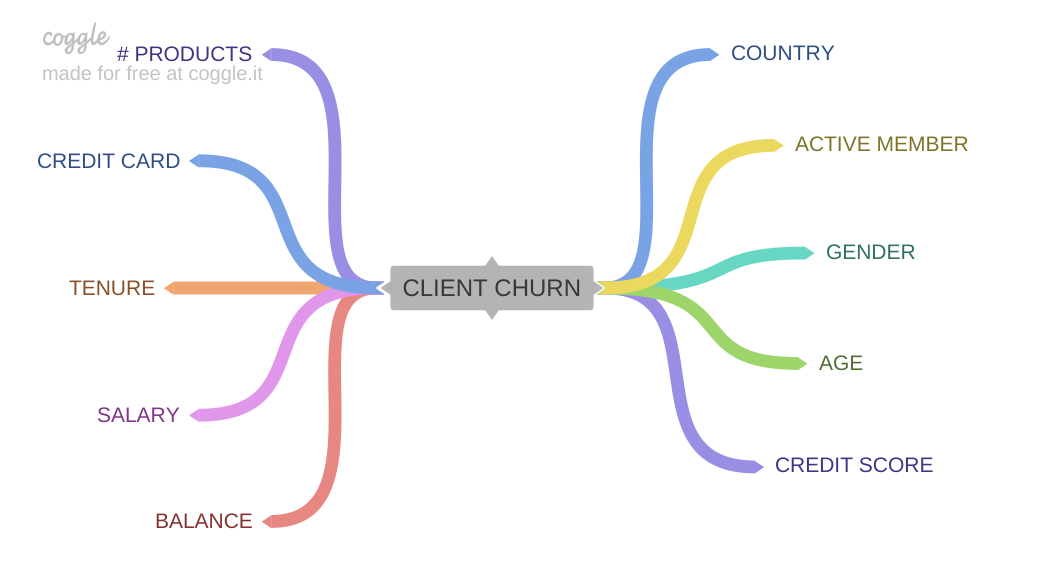

In [30]:
Image('images/CLIENT_CHURN.png')

# Exploratory Data Analysis

In [90]:
df4 = df3.copy()

## Numerical Features

In [32]:
mask = (df4.exited == 1)

### Distributions

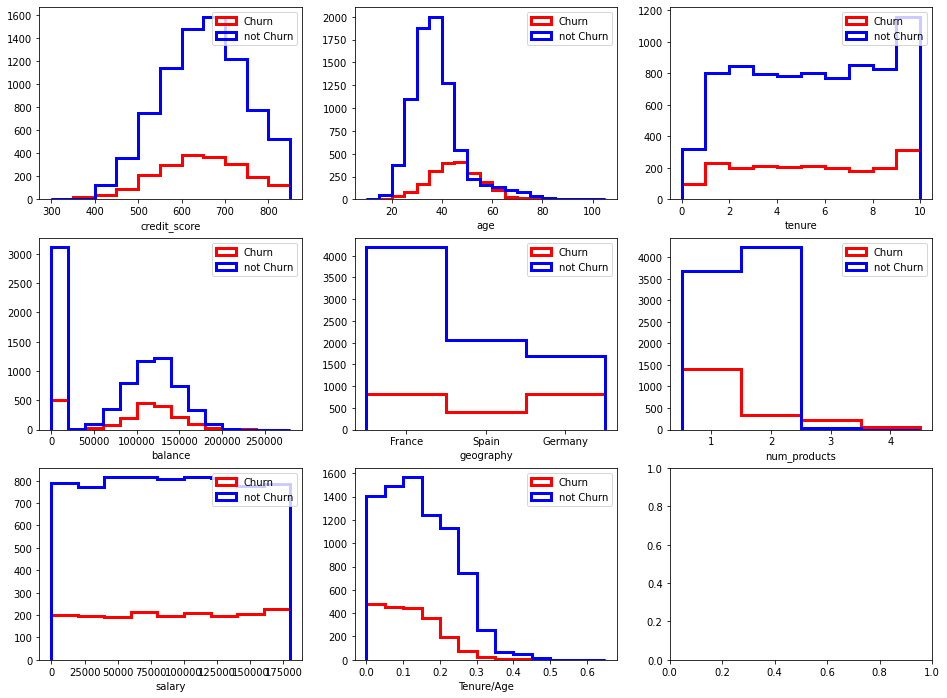

In [52]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

cols = ['credit_score', 'age', 'tenure',
        'balance', 'geography', 'num_products',
        'salary']
bins = [np.arange(300, 900, 50), np.arange(10, 110, 5), np.arange(0, 11, 1),
        np.arange(0, 300_000, 20_000), np.arange(-0.5, 3.5, 1), np.arange(.5, 5.5, 1),
        np.arange(0, 200_000, 20_000)]

normed = False
for iax, col, ibin in zip(ax.ravel(), cols, bins):
    plot_hist(iax, df4, col, ibin, normed, mask=mask)
    
ibin = np.arange(0, 0.7, 0.05)
ax[2, 1].hist(df4.tenure[mask] / df4.age[mask], **hargs(bins=ibin, normed=normed))
ax[2, 1].hist(df4.tenure[~mask] / df4.age[~mask], **hargs(bins=ibin, normed=normed, c='b', label='not Churn'))
ax[2, 1].set_xlabel('Tenure/Age')
ax[2, 1].legend()

plt.show()

### Normalized Distributions

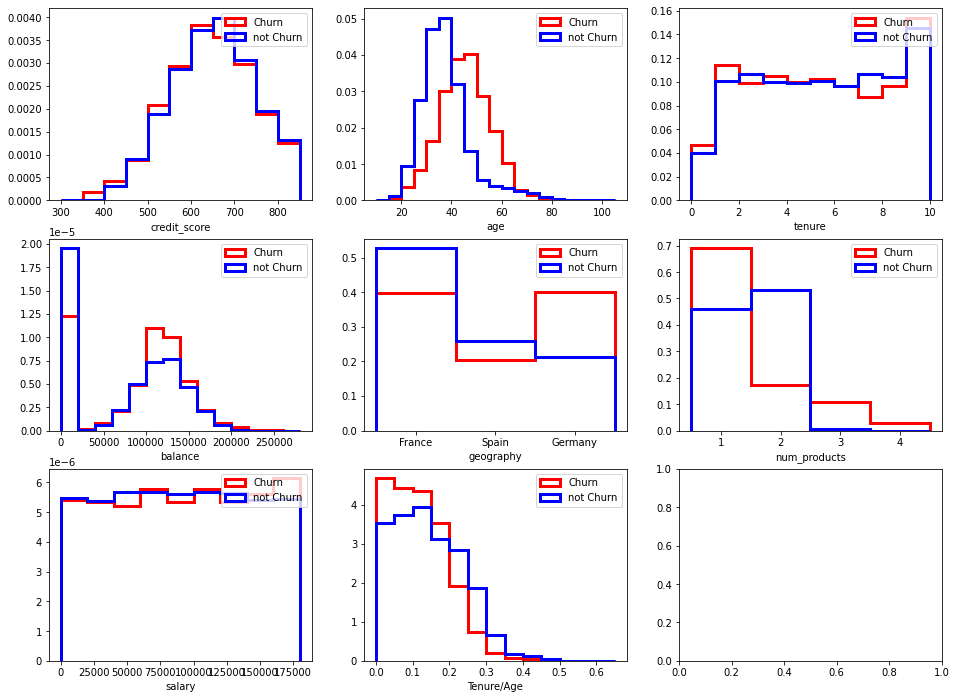

In [53]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

normed = True
for iax, col, ibin in zip(ax.ravel(), cols, bins):
    plot_hist(iax, df4, col, ibin, normed, mask=mask)
    
ibin = np.arange(0, 0.7, 0.05)
ax[2, 1].hist(df4.tenure[mask] / df4.age[mask], **hargs(bins=ibin, normed=normed))
ax[2, 1].hist(df4.tenure[~mask] / df4.age[~mask], **hargs(bins=ibin, normed=normed, c='b', label='not Churn'))
ax[2, 1].set_xlabel('Tenure/Age')
ax[2, 1].legend()

plt.show()

### Distributions by Country

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
(ax1, ax2), (ax3, ax4) = ax
#(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = ax

mask = (df1.exited == 1)

var = 'salary'
normed = False
bins = np.arange(0, 200_000, 20_000)
ax1.hist(df1.loc[(df1.geography == 'Germany'), var], **hargs(bins=bins, normed=normed, c='k', label='GER'))       
ax1.hist(df1.loc[(df1.geography == 'Spain'), var], **hargs(bins=bins, normed=normed, c='r', label='SPA'))
ax1.hist(df1.loc[(df1.geography == 'France'), var], **hargs(bins=bins, normed=normed, c='b', label='FRA'))
ax1.set_xlabel('Salary')
ax1.legend(loc='lower center')

normed = True
ax2.hist(df1.loc[(df1.geography == 'Germany') & mask, var], **hargs(bins=bins, normed=normed, c='k', label='GER Churn'))       
ax2.hist(df1.loc[(df1.geography == 'Germany') & ~mask, var], **hargs(bins=bins, normed=normed, c='k', label='GER not Churn'), linestyle='dashed')
ax2.hist(df1.loc[(df1.geography == 'Spain') & mask, var], **hargs(bins=bins, normed=normed, c='r', label='SPA Churn'))       
ax2.hist(df1.loc[(df1.geography == 'Spain') & ~mask, var], **hargs(bins=bins, normed=normed, c='r', label='SPA not Churn'), linestyle='dashed')
ax2.hist(df1.loc[(df1.geography == 'France') & mask, var], **hargs(bins=bins, normed=normed, c='b', label='FRA Churn'))       
ax2.hist(df1.loc[(df1.geography == 'France') & ~mask, var], **hargs(bins=bins, normed=normed, c='b', label='FRA not Churn'), linestyle='dashed')
ax2.set_xlabel('Salary')
ax2.legend(loc='lower center')

var = 'balance'
normed = True
bins = np.arange(0, 300_000, 20_000)
ax3.hist(df1.loc[(df1.geography == 'Germany'), var], **hargs(bins=bins, normed=normed, c='k', label='GER'))       
ax3.hist(df1.loc[(df1.geography == 'Spain')&(df1.balance > 0), var], **hargs(bins=bins, normed=normed, c='r', label='SPA'))
ax3.hist(df1.loc[(df1.geography == 'France')&(df1.balance > 0), var], **hargs(bins=bins, normed=normed, c='b', label='FRA'))
ax3.set_xlabel('balance')
ax3.legend(loc='upper right')

normed = True
ax4.hist(df1.loc[(df1.geography == 'Germany') & mask, var], **hargs(bins=bins, normed=normed, c='k', label='GER Churn'))       
ax4.hist(df1.loc[(df1.geography == 'Germany') & ~mask, var], **hargs(bins=bins, normed=normed, c='k', label='GER not Churn'), linestyle='dashed')
ax4.hist(df1.loc[(df1.geography == 'Spain') & mask, var], **hargs(bins=bins, normed=normed, c='r', label='SPA Churn'))       
ax4.hist(df1.loc[(df1.geography == 'Spain') & ~mask, var], **hargs(bins=bins, normed=normed, c='r', label='SPA not Churn'), linestyle='dashed')
ax4.hist(df1.loc[(df1.geography == 'France') & mask, var], **hargs(bins=bins, normed=normed, c='b', label='FRA Churn'))       
ax4.hist(df1.loc[(df1.geography == 'France') & ~mask, var], **hargs(bins=bins, normed=normed, c='b', label='FRA not Churn'), linestyle='dashed')
ax4.set_xlabel('balance')
ax4.legend(loc='upper right')

plt.show()

In [ ]:
df1.loc[(df1.balance < 2000)&(df1.geography == 'Germany')]

In [54]:
attributes = ['age', 'balance', 'tenure', 'num_products',
              'credit_score', 'salary', 'country']

### Correlation Matrices

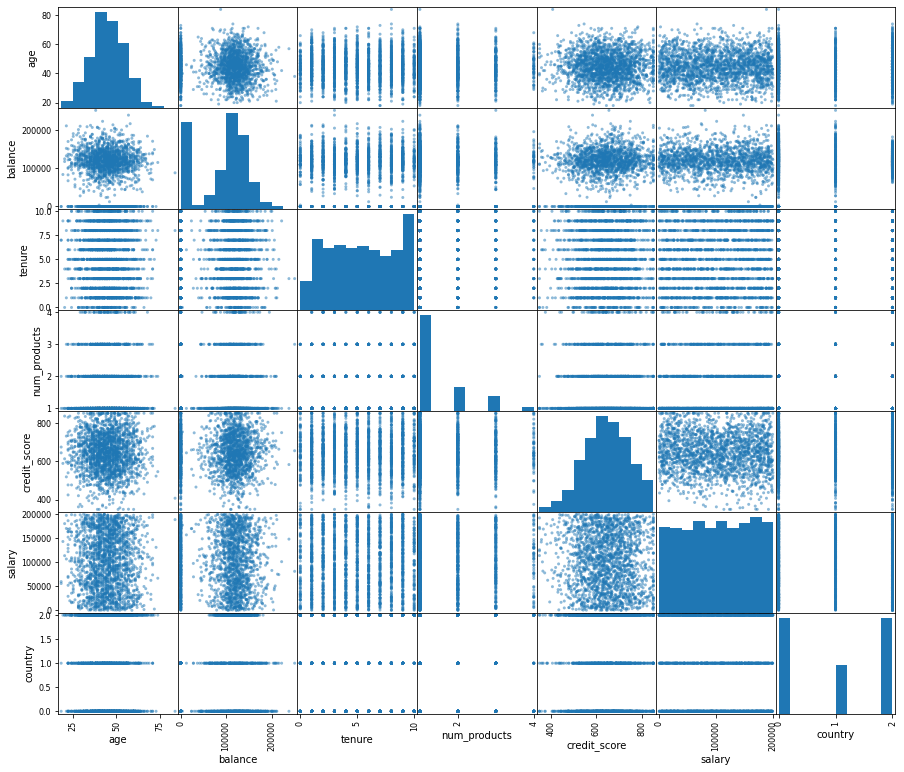

In [56]:
scatter_matrix(df4[mask][attributes], figsize=(15, 13))
plt.show()

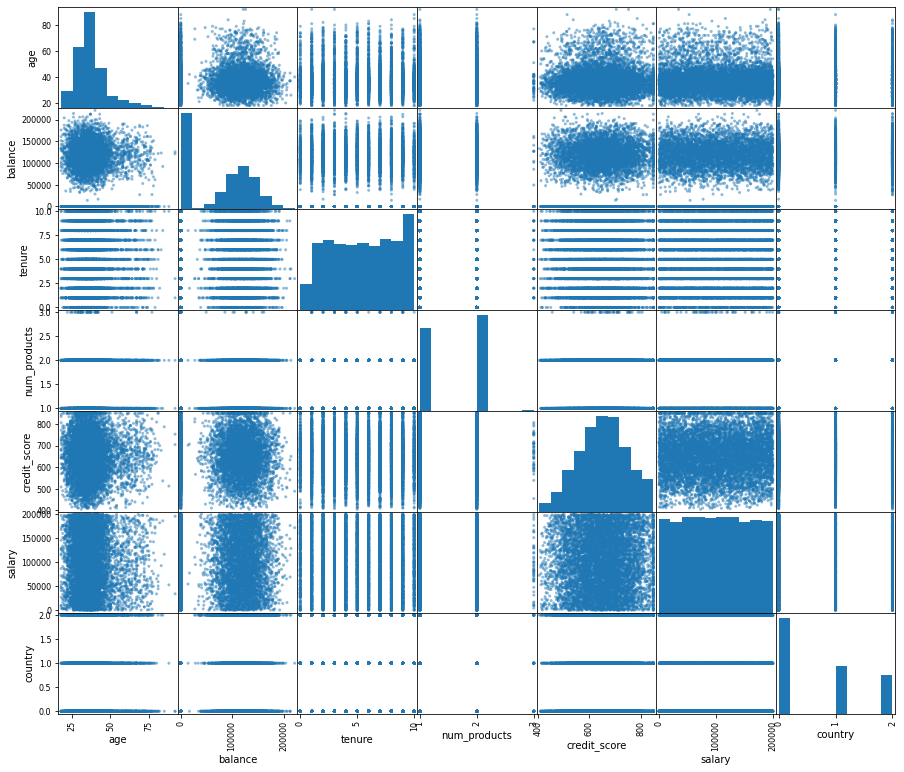

In [57]:
scatter_matrix(df4[~mask][attributes], figsize=(15, 13))
plt.show()

## Categorical Features

### Correlations with Numerical Features

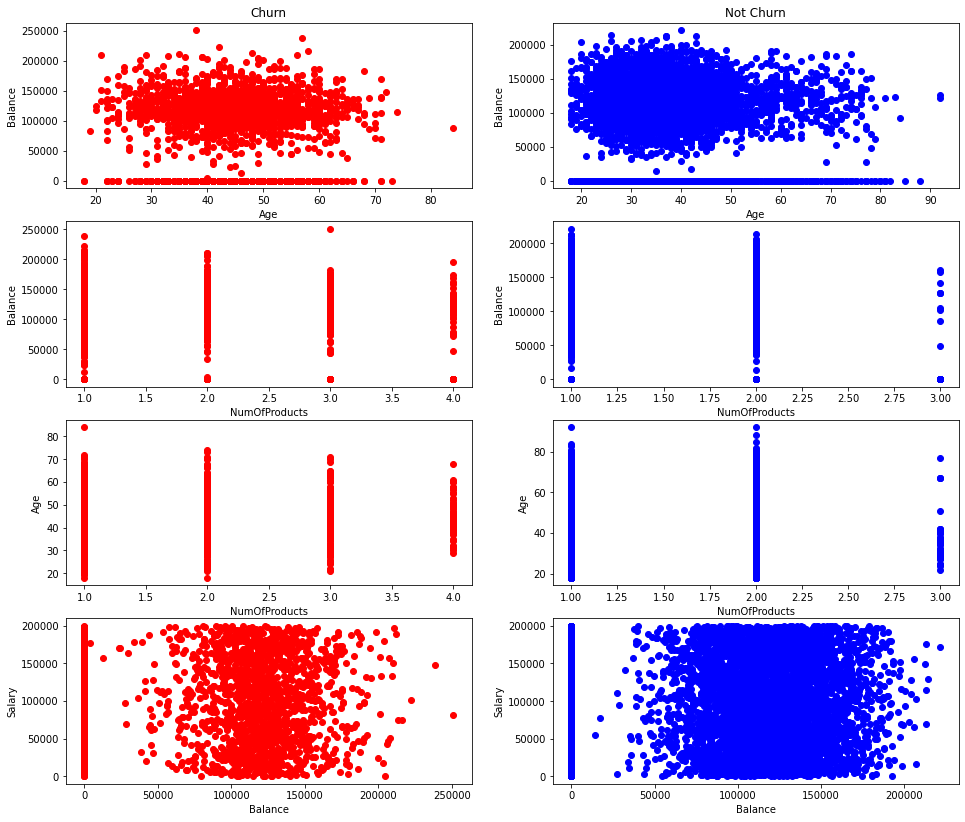

In [59]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 14))
(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8) = ax

ax1.scatter(x=df4.age[mask], y=df4.balance[mask], label='Churn', color='r')  
ax1.set_title('Churn')
ax1.set_xlabel('Age')
ax1.set_ylabel('Balance')

ax2.scatter(x=df4.age[~mask], y=df4.balance[~mask], label='not Churn', color='b')
ax2.set_title('Not Churn')
ax2.set_xlabel('Age')
ax2.set_ylabel('Balance')

ax3.scatter(x=df4.num_products[mask], y=df4.balance[mask], label='Churn', color='r')  
ax3.set_xlabel('NumOfProducts')
ax3.set_ylabel('Balance')

ax4.scatter(x=df4.num_products[~mask], y=df4.balance[~mask], label='not Churn', color='b')
ax4.set_xlabel('NumOfProducts')
ax4.set_ylabel('Balance')

ax5.scatter(x=df4.num_products[mask], y=df4.age[mask], label='Churn', color='r')  
ax5.set_xlabel('NumOfProducts')
ax5.set_ylabel('Age')

ax6.scatter(x=df4.num_products[~mask], y=df4.age[~mask], label='not Churn', color='b')
ax6.set_xlabel('NumOfProducts')
ax6.set_ylabel('Age')

ax7.scatter(x=df4.balance[mask], y=df4.salary[mask], label='Churn', color='r')
ax7.set_xlabel('Balance')
ax7.set_ylabel('Salary')

ax8.scatter(x=df4.balance[~mask], y=df4.salary[~mask], label='not Churn', color='b')
ax8.set_xlabel('Balance')
ax8.set_ylabel('Salary')

plt.show()

### Frequency Tables

In [61]:
table = df4.groupby(['exited', 'credit_card']).agg('count').balance.unstack()
print_prop(table)
table

Total of credit_card = 10000
Proportion of credit_card==0: 29.45%
Proportion of credit_card==1: 70.55%
Proportion of credit_card==0 that Churned: 20.81%
Proportion of credit_card==1 that Churned: 20.18%


credit_card,0,1
exited,,
0,2332,5631
1,613,1424


In [91]:
table = df4.groupby(['exited', 'gender']).agg('count').balance.unstack()
print_prop(table)
table

Total of gender = 10000
Proportion of gender==0: 54.57%
Proportion of gender==1: 45.43%
Proportion of gender==0 that Churned: 16.46%
Proportion of gender==1 that Churned: 25.07%


gender,0,1
exited,,
0,4559,3404
1,898,1139


In [64]:
table = df4.groupby(['exited', 'active_member']).agg('count').balance.unstack()
print_prop(table)
table

Total of active_member = 10000
Proportion of active_member==0: 48.49%
Proportion of active_member==1: 51.51%
Proportion of active_member==0 that Churned: 26.85%
Proportion of active_member==1 that Churned: 14.27%


active_member,0,1
exited,,
0,3547,4416
1,1302,735


In [65]:
table = df4.groupby(['exited', 'geography']).agg('count').balance.unstack()
print_prop3(table)
table

Total of geography = 10000
Proportion of France: 50.14%
Proportion of Spain: 24.77%
Proportion of Germany: 25.09%
Proportion of France that Churned: 16.15%
Proportion of Spain that Churned: 16.67%
Proportion of Germany that Churned: 32.44%


geography,France,Germany,Spain
exited,,,
0,4204,1695,2064
1,810,814,413


### Frequency Plots

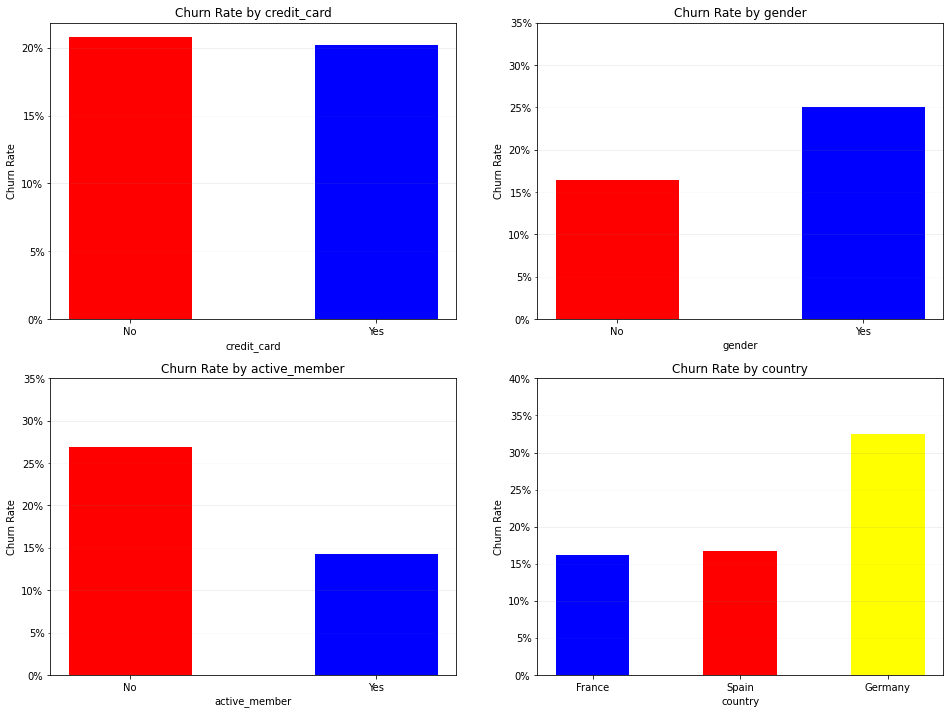

In [92]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
(ax1, ax2), (ax3, ax4) = ax

cols = ['credit_card', 'gender', 'active_member', 'country']
for iax, col, ymax in zip(ax.ravel(), cols, [.3, .4, .4, .5]):
    draw_rate(iax, df4, col)
    draw_grid(iax, ymax)
    
plt.show()

### Frequency Plots by Country

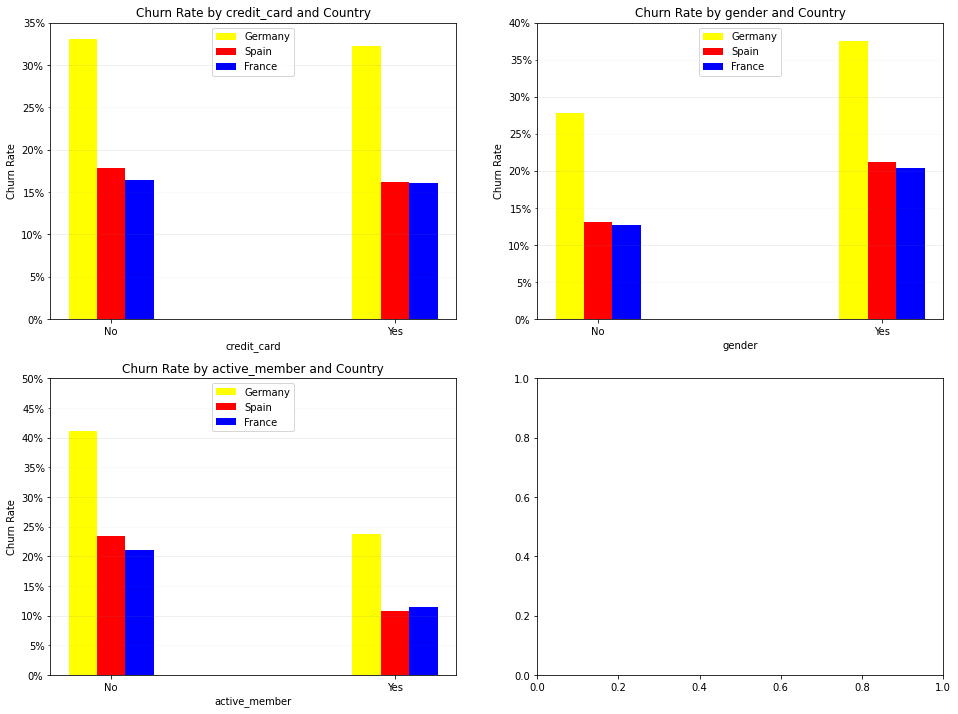

In [93]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
(ax1, ax2), (ax3, ax4) = ax

cols = ['credit_card', 'gender', 'active_member']
for iax, col, ymax in zip(ax.ravel(), cols, [.4, .5, .6]):
    draw_rate_country(iax, df4, col)
    draw_grid(iax, ymax)


plt.show()

# Data Preparation

In [94]:
df5 = df4.copy()

## Normalization

In [95]:
cols_norm = ['balance', 'age']
scaler = StandardScaler()

In [96]:
data = df5[cols_norm].copy()
scaler.fit(data)
df5[cols_norm] = scaler.transform(data)

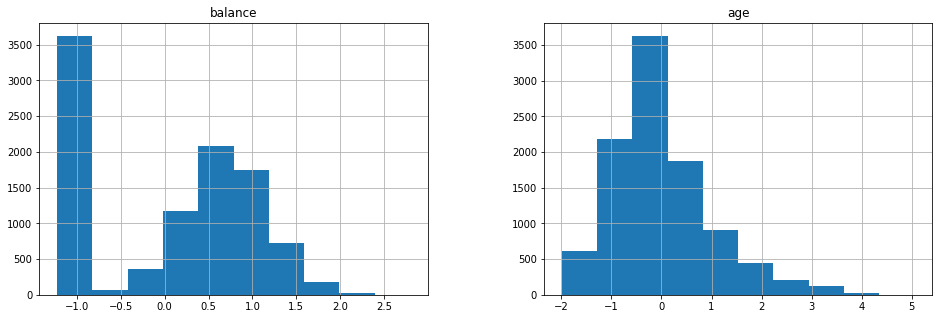

In [97]:
df5[cols_norm].hist(figsize=(16,5));

## Rescaling

In [98]:
cols_mms = ['credit_score', 'tenure', 'salary']
mms = MinMaxScaler()

In [99]:
data = df5[cols_mms].copy()
mms.fit(data)
df5[cols_mms] = mms.transform(data)

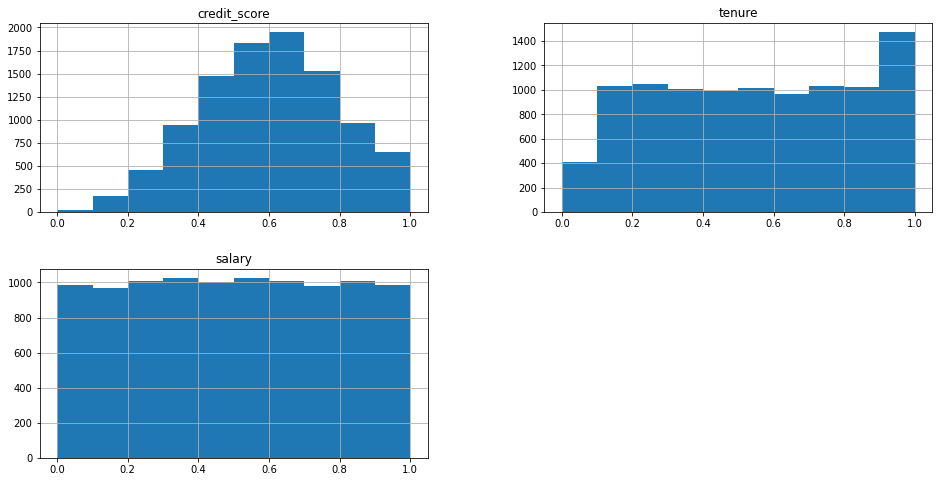

In [100]:
df5[cols_mms].hist(figsize=(16,8));

## Transformation

### Encoding

In [172]:
cols_ohe = ['geography', 'gender']
#cols_ohe = ['geography']
ohe = OneHotEncoder(sparse=False)

In [178]:
df5[cols_ohe].head(10)

,geography,gender
0,France,1
1,Spain,1
2,France,1
3,France,1
4,Spain,1
5,Spain,0
6,France,0
7,Germany,1
8,France,0
9,France,0


In [176]:
ohe.fit_transform(df5[cols_ohe])[:10]

array([[1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0.]])

## Summary - Make Column Transformer

In [109]:
cols_norm = ['balance', 'age']
scaler = StandardScaler()

cols_mms = ['credit_score', 'tenure', 'salary']
mms = MinMaxScaler()

cols_ohe = ['geography', 'gender']
ohe = OneHotEncoder()

In [110]:
ct = make_column_transformer((scaler, cols_norm), (mms, cols_mms), (ohe, cols_ohe), remainder='passthrough')

### Testing the Column Transformer

In [126]:
test = df2.copy()
test.iloc[[0, 5]]

,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country
0,619,France,1,42,2,0.00,1,1,1,101348.88,1,0
5,645,Spain,0,44,8,113755.78,2,1,0,149756.71,1,1


In [128]:
ct.fit_transform(test)[[0, 5]]

array([[-1.226,  0.294,  0.538,  0.2  ,  0.507,  1.   ,  0.   ,  0.   ,
         0.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  0.   ],
       [ 0.597,  0.484,  0.59 ,  0.8  ,  0.749,  0.   ,  0.   ,  1.   ,
         1.   ,  0.   ,  2.   ,  1.   ,  0.   ,  1.   ,  1.   ]])

# Machine Learning Models

In [179]:
df6 = reload_data()
print(', '.join(df6.columns))

credit_score, geography, gender, age, tenure, balance, num_products, credit_card, active_member, salary, exited


In [ ]:
#make_pipeline(ct, model)

# Pergunta 1 - Qual a taxa de Churn atual da empresa?

In [ ]:
total_churn = df1.exited.sum()
churn_ratio = total_churn / len(df1)

print(f'Numero total de churns = {total_churn}')
print(f'Taxa de churn = {100.*churn_ratio:.2f}%')

# Como a taxa de Churn varia por mês?